## Differential expression analysis

Differential expression analysis is a crucial step in analyzing transcriptomic data, especially in understanding how gene expression changes across different conditions, such as disease states or experimental treatments.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = 'transcriptomic_preproc_clustering'
RESULTS_PATH = 'results/'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 247976 × 2789
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Studying feature variance

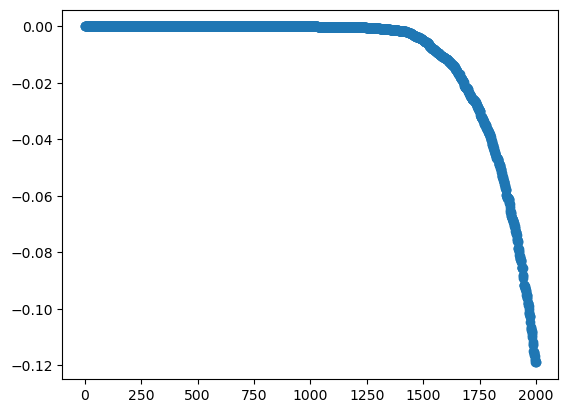

In [3]:
matrix = adata.X
#matrix = matrix.to_dense()
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances);

Data normalization

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:377: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [5]:
print('Number of genes:', adata.n_vars)
print('Number of cells:', adata.n_obs)

Number of genes: 2789
Number of cells: 247976


Clustering

In [6]:
default_markers_df = pd.DataFrame(adata.obs['leiden'])
default_markers_df = default_markers_df.rename(columns={'leiden': 'cluster'})
default_markers_df.index.name = 'cell'
default_markers_df['cluster'] = default_markers_df['cluster'].astype(int) + 1
num_clusters_default = len(default_markers_df['cluster'].unique())

In [7]:
default_markers_df

,cluster
cell,
AAACCCAAGACTGTTC-1,5
AAACCCAAGGATCATA-1,8
AAACCCAGTTATTCTC-1,7
AAACCCATCATGAGGG-1,8
AAACGAAAGCCAGTAG-1,7
...,...
TTTGCGCGTGCAACGA-1-PTC85037-PBMC,2
TTTGCGCTCCGTAGTA-1-PTC85037-PBMC,2
TTTGGTTCACCACGTG-1-PTC85037-PBMC,11


## Differential expression on default clusters

In [8]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # default='t-test', wilcoxon suggested in the tutorial

In [9]:
num_clusters_default

20

Save markers

In [10]:

from scipy.stats import rankdata

In [11]:
top_number_of_markers = 10

In [12]:
default_markers_df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(num_clusters_default):
    indices = np.argsort(adata.uns['rank_genes_groups']['pvals_adj'][str(i)])
    genes = adata.uns['rank_genes_groups']['names'][str(i)][indices][:top_number_of_markers]
    ranks = rankdata(adata.uns['rank_genes_groups']['pvals_adj'][str(i)][indices][:top_number_of_markers], method="ordinal")
    temp_df = pd.DataFrame(
        np.column_stack((genes, [i+1 for _ in range(top_number_of_markers)], ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    default_markers_df = pd.concat([default_markers_df, temp_df], ignore_index=True)

In [13]:
default_markers_df['cluster'] = default_markers_df['cluster'].astype(int)
default_markers_df['rank'] = default_markers_df['rank'].astype(int)

In [14]:
default_markers_df

,gene,cluster,rank
0,STEAP3-AS1,1,1
1,FOS,1,2
2,GK,1,3
3,LINC01238,1,4
4,SULT1A1,1,5
...,...,...,...
195,TBC1D4,20,6
196,IGHD2-2,20,7
197,AC009041.3,20,8
198,RTL1,20,9


In [15]:
default_markers_df.to_csv(f'{RESULTS_PATH}trans_top_10_markers_per_cluster.csv', index=False)

### Plots